In [1]:
from visual_transformer import *

In [2]:
from game import *

pygame 2.6.1 (SDL 2.28.4, Python 3.12.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)

NVIDIA GeForce GTX 1070


In [4]:
device = torch.device('cuda:0')

In [5]:
game_settings = BIG_tool_use_advanced_2_5
game_settings.gameSize = 224 # for compatibility with brain's expected size
G = discreteGame(game_settings)

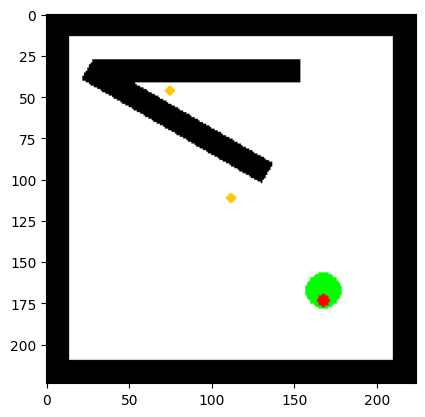

In [6]:
import matplotlib.pyplot as plt
plt.imshow(G.getData())

In [7]:
def quick_display(torch_img):
    clean = torch_img.detach().cpu()
    right_order = torch.permute(clean, (1, 2, 0))
    array = right_order.numpy()
    plt.imshow(array)

In [8]:
def get_images(settings_batch, device=device):
    batch_size = len(settings_batch)
    img = torch.zeros(batch_size, 224, 224, 3)
    for i in range(batch_size):
        G2 = discreteGame(settings_batch[i])
        img[i] = torch.tensor(G2.getData())
    img = torch.permute(img, (0, 3, 1, 2)).contiguous().to(device)
    return img

In [9]:
def get_settings_batch(batch_size):
    return [G.random_bare_settings(gameSize=224, max_agent_offset=0.5) for i in range(batch_size)]

In [12]:
batch_size = 4

In [13]:
S = get_settings_batch(batch_size)

In [14]:
imgs = get_images(S)

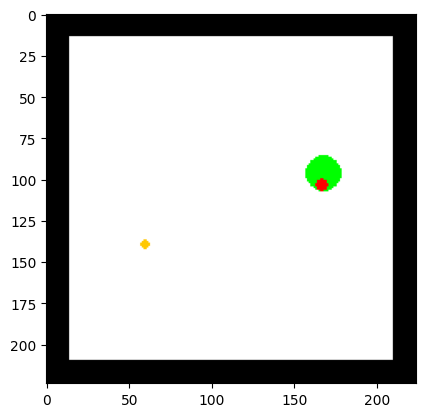

In [15]:
quick_display(imgs[2])

In [16]:
imgs[2].size()

torch.Size([3, 224, 224])

In [17]:
red = torch.tensor([1.0, 0, 0], device=device)

In [24]:
red.unsqueeze(1).unsqueeze(1)

tensor([[[1.]],

        [[0.]],

        [[0.]]], device='cuda:0')

In [28]:
diff = imgs[2] - red.unsqueeze(1).unsqueeze(1)

In [26]:
a = torch.randn(10)
b = torch.randn(10)
c = a * b
print(c.shape)

torch.Size([10])


In [27]:
c

tensor([-0.2203, -1.1163, -0.6501, -0.0094, -0.1146,  0.1961,  0.4623, -0.8424,
         0.3580,  0.0290])

In [30]:
square = diff * diff
square.size()

torch.Size([3, 224, 224])

In [31]:
mag = square.sum(0)
mag.size()

torch.Size([224, 224])

In [55]:
def get_color_mask(img, c_vector, epsilon=3.0/(255*255)): # needs larger epsilon later; test!
    diff = img - (c_vector / 255).unsqueeze(1).unsqueeze(1)
    mag = (diff*diff).sum(0)
    #print(torch.min(mag))
    return (mag < epsilon)

In [69]:
mask_black = get_color_mask(imgs[2], torch.tensor(G.BLACK, device=device), epsilon=0.01)

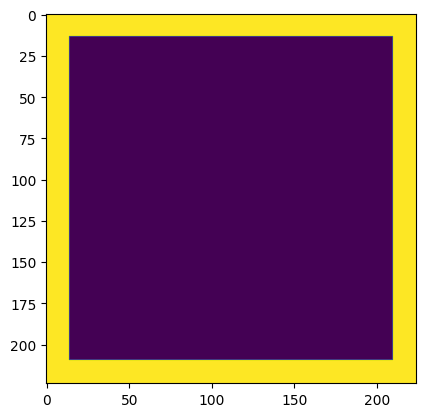

In [70]:
plt.imshow(mask_black.detach().cpu().numpy())

In [71]:
imgs[2].shape

torch.Size([3, 224, 224])

In [84]:
scale = torch.arange(224, device=device) / 224
y_scale = scale
x_scale = scale.unsqueeze(1) # remember, the way it's displayed is a little backwards, unfortunately

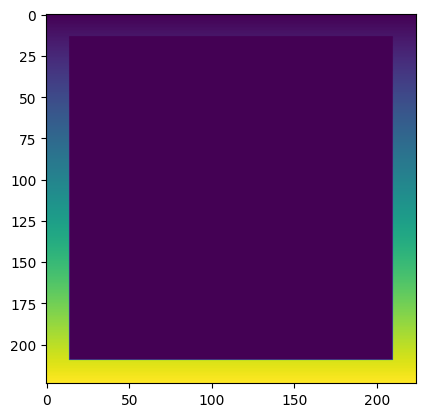

In [85]:
plt.imshow((mask_black*scale.unsqueeze(1)).detach().cpu().numpy())

In [86]:
def get_mask_center(color_mask):
    elems = torch.sum(color_mask).item()
    x = torch.sum(color_mask * x_scale).item() / elems
    y = torch.sum(color_mask * y_scale).item() / elems
    return x, y

In [87]:
mask_gold = get_color_mask(imgs[2], torch.tensor(G.GOLD, device=device), epsilon=0.01)
computed_gold_center = get_mask_center(mask_gold)
computed_gold_center

(0.6227678855260214, 0.265625)

In [88]:
S[2].__dict__

{'gameSize': 224,
 'direction': 6.173670871548942,
 'agent_x': 0.4351363051580081,
 'agent_y': 0.7507398367554926,
 'agent_r': 0.05,
 'gold_r': 0.015625,
 'gold': [(0.6269440386902327, 0.2720851219963125)],
 'walls': [[0, 0, 0.0625, 1.0, 0],
  [0, 0, 1.0, 0.0625, 0],
  [0, 0.9375, 1.0, 0.0625, 0],
  [0.9375, 0, 0.0625, 1.0, 0]]}

In [89]:
# Ok. Basic outlines set.
# I *really* want a general solution, not just one that relies on there being 1 gold
# The walls are too hard for now; leaving that alone for the time being.
# Will do that next time

In [91]:
torch.sum(mask_gold)

tensor(24, device='cuda:0')

In [93]:
14 / 224

0.0625

In [94]:
G.settings.gold_r

0.015625

In [96]:
torch.argmax(mask_gold * x_scale)

tensor(31867, device='cuda:0')

In [97]:
(mask_gold*x_scale).shape

torch.Size([224, 224])

In [98]:
import math

# THis is a heuristic
# It will not work if gold pieces are very close together.
# However, i think it'll be useful and relatively fast in the time being
def get_gold_centers(gold_mask, gold_r):
    centers = []
    offset = math.ceil(gold_r * 224)
    ys = gold_mask * y_scale
    M = torch.argmax(ys)
    while M > 0:
        sample_x, sample_y = divmod(M.item(), 224)
        # I *could* write a complex function here, but I don't need to by a property of circles.
        center_x = sample_x / 224.0
        center_y = sample_y / 224.0 - gold_r
        centers.append((center_x, center_y))
        ys[sample_x - offset-1:sample_x + offset+1, sample_y - 2*offset-1:sample_y + 1] = 0
        M = torch.argmax(ys)
    return centers


In [99]:
# Here we go. I think I will still use the 'cheating', simpler version on bare games (which are the default anyway)
# since it's a lot faster, but what I wrote there should work well.